# Heart Attack Prediction

In [1]:
%matplotlib inline

import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from pandas import Series
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

import eli5 
from eli5.sklearn import PermutationImportance

import itertools

Using TensorFlow backend.


In [2]:
def plot_cf_matrix_and_roc(model, 
                           X_train, 
                           y_train,
                           X_test, 
                           y_test,
                           y_pred, 
                           classes=[0,1],
                           normalize=False,
                           cmap=plt.cm.Blues):
    metrics_list = []
    
    # the main plot
    plt.figure(figsize=(15,5))

    # the confusion matrix
    plt.subplot(1,2,1)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.title("Normalized confusion matrix")
    else:
        plt.title('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # the ROC curve
    plt.subplot(1,2,2)
    tmp = model.fit(X_train, y_train.ravel())
    y_pred_sample_score = tmp.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)
    roc_auc = auc(fpr,tpr)

    # Plot ROC
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.0])
    plt.ylim([-0.01,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()
    
    # the result metrix
    summary_df = pd.DataFrame([[str(np.unique( y_pred )),
                               str(round(metrics.precision_score(y_test, y_pred.round()),3)),
                               str(round(metrics.accuracy_score(y_test, y_pred.round()),3)),
                               str(round(metrics.recall_score(y_test, y_pred.round(), average='binary'),3)),
                               str(round(metrics.roc_auc_score(y_test, y_pred.round()),3)),
                               str(round(roc_auc,3)),
                               str(round(metrics.f1_score(y_test, y_pred.round(), average='binary'),3))]], 
                              columns=['Class', 'Precision', 'Accuracy', 'Recall', 'ROC-AUC', 'AUC', 'F1-score'])
    # print the metrics
    print("\n");
    print(summary_df);
    print("\n");
    
    plt.show()

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def summary(df):
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

In [5]:
from scipy import stats
from scipy.stats import norm, skew

def numeric_transform(df, var, transform_type = 'log'):
    """ possible values: 'log', 'log1p', 'log10', 'sqrt' """
    print('Transform with: '+ transform_type+"\n");
    
    # Plot histogram and probability
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    sns.distplot(df[var] , fit=norm);
    (mu, sigma) = norm.fit(df[var])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(var+' distribution')
    plt.subplot(1,2,2)
    res = stats.probplot(df[var], plot=plt)
    plt.suptitle('Before transformation')
    
    # Apply transformation
    if transform_type == 'log':
        df[var] = np.log(df[var])
    elif transform_type == 'log10':
        df[var] = np.log10(df[var] )
    elif transform_type == 'sqrt':
        df[var] = np.sqrt(df[var] )
        
    # New prediction
    y_train = df[var].values
    y_train_orig = df[var]

    # Plot histogram and probability after transformation
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    sns.distplot(df[var] , fit=norm);
    (mu, sigma) = norm.fit(df[var])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(var+' distribution')
    plt.subplot(1,2,2)
    res = stats.probplot(df[var], plot=plt)
    plt.suptitle('After transformation')

In [6]:
def to_numeric_mean(df, cols):
    for col in cols:
        data.loc[data[col].isnull(), col] = 0
        data[col] = pd.to_numeric(data[col])
        data[col].fillna((data[col].mean()), inplace=True)
    return df

In [7]:
def to_numeric_most_frequent(df, cols):
    for col in cols:
        data.loc[data[col].isnull(), col] = 0
        data[col] = pd.to_numeric(data[col])
        data[col].fillna((data[col].value_counts().index[0]), inplace=True)
    return df

In [8]:
data = pd.read_csv("../input/heart-attack-prediction/data.csv")

In [9]:
data.shape

(294, 14)

In [10]:
summary(data)

,index,dtypes,Missing,Uniques
0,age,int64,0,38
1,sex,int64,0,2
2,cp,int64,0,4
3,trestbps,object,0,32
4,chol,object,0,154
5,fbs,object,0,3
6,restecg,object,0,4
7,thalach,object,0,72
8,exang,object,0,3
9,oldpeak,float64,0,10


In [11]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.000,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.000,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.000,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.000,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.000,?,?,?,0


In [12]:
data.replace('?', np.nan, inplace=True)

In [13]:
data.rename({'num       ':'num'},axis=1,inplace=True)

In [14]:
summary(data)

,index,dtypes,Missing,Uniques
0,age,int64,0,38
1,sex,int64,0,2
2,cp,int64,0,4
3,trestbps,object,1,31
4,chol,object,23,153
5,fbs,object,8,2
6,restecg,object,1,3
7,thalach,object,1,71
8,exang,object,1,2
9,oldpeak,float64,0,10


## Drop the columns with more than 5% of NaN values

In [15]:
data = data.drop(columns=['slope', 'ca', 'thal'])

## Replace the nan values and convert to numeric

In [16]:
data = to_numeric_mean(data, ['chol', 'trestbps', 'thalach'])

In [17]:
data = to_numeric_mean(data, ['restecg', 'exang', 'fbs'])

In [18]:
summary(data)

,index,dtypes,Missing,Uniques
0,age,int64,0,38
1,sex,int64,0,2
2,cp,int64,0,4
3,trestbps,int64,0,32
4,chol,int64,0,154
5,fbs,int64,0,2
6,restecg,int64,0,3
7,thalach,int64,0,72
8,exang,int64,0,2
9,oldpeak,float64,0,10


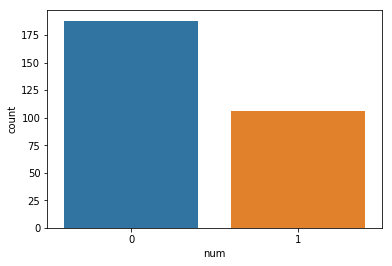

In [19]:
sns.countplot(data['num'])

In [20]:
count_no_lead = len(data[data['num']==0])
count_lead = len(data[data['num']==1])
pct_of_no_sub = count_no_lead/(count_no_lead+count_lead)*100
pct_of_sub = count_lead/(count_no_lead + count_lead)*100
print('{} {} % Sales '.format(count_lead, pct_of_sub))
print('{} {} % No-Sales '.format(count_no_lead, pct_of_no_sub))

106 36.054421768707485 % Sales 
188 63.94557823129252 % No-Sales 


## Correlation with the target variable

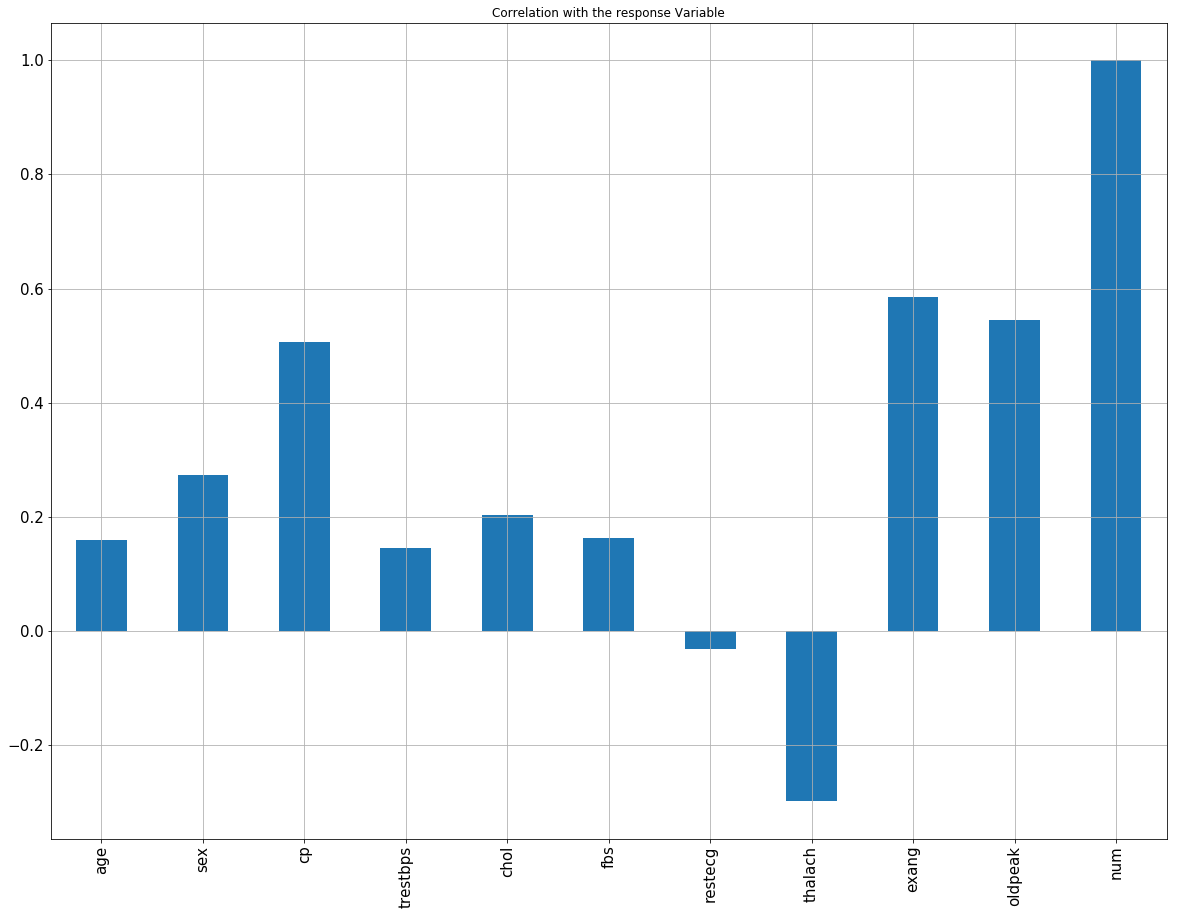

In [21]:
data.corrwith(data.num).plot.bar(figsize=(20,15), 
                                              title="Correlation with the response Variable", 
                                              fontsize=15, rot=90, grid=True)

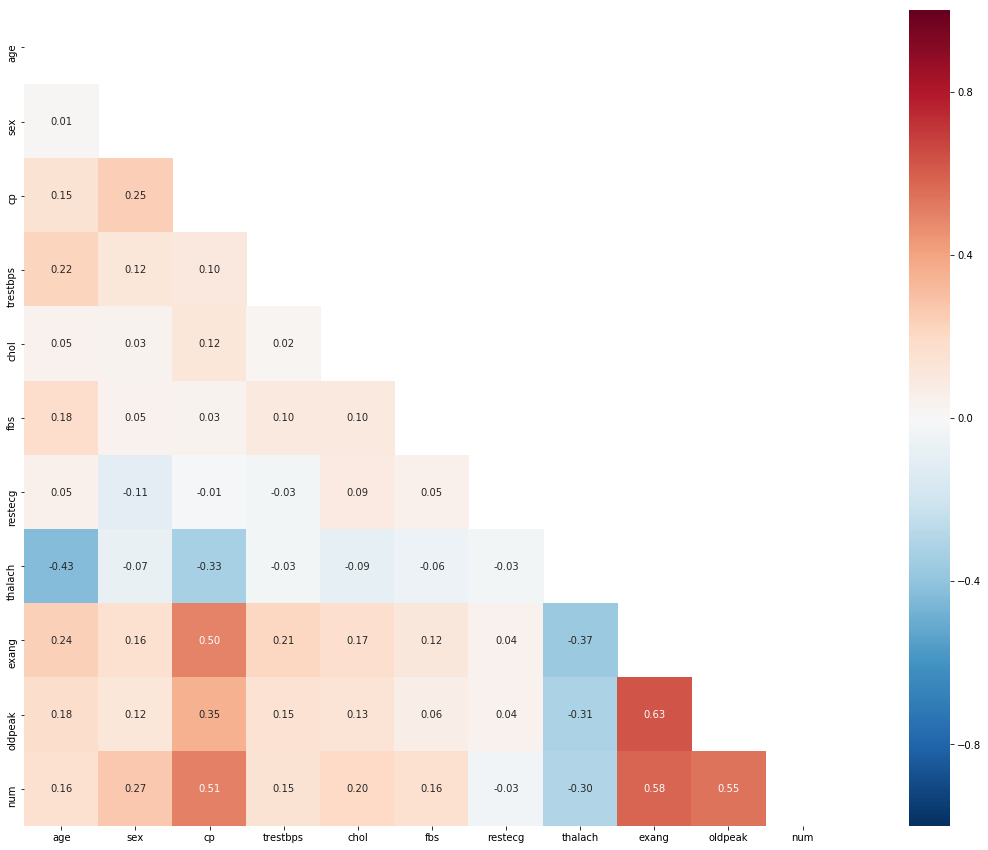

In [22]:
plt.figure(figsize=(25, 15))
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, cmap='RdBu_r', vmin=-1, vmax=1, annot=True, fmt='.2f');

## Standardisation for all variables

In [23]:
from sklearn.preprocessing import MinMaxScaler
col_names = data.columns
features = data[col_names]
scaler = MinMaxScaler(feature_range = (0,1)).fit(features.values)
features = scaler.transform(features.values)
data[col_names] = features

In [24]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,0.000,1.000,0.333,0.650,0.219,0.000,1.000,0.974,0.000,0.000,0.000
1,0.026,1.000,0.333,0.600,0.403,0.000,0.000,0.842,0.000,0.000,0.000
2,0.026,1.000,0.333,0.700,0.000,0.000,0.000,0.895,0.000,0.000,0.000
3,0.053,0.000,0.000,0.850,0.393,0.000,0.500,0.895,0.000,0.000,0.000
4,0.079,0.000,0.333,0.500,0.363,0.000,0.500,0.789,0.000,0.000,0.000


## Split the data to train (70%) and test (30%)

In [25]:
X = data.drop(columns=['num'])
y = data['num']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))
print ("\n")
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Counts of label '0': {}".format(sum(y_train==0)))
print("Counts of label '1': {}".format(sum(y_train==1)))
print ("\n")
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)
print("Counts of label '0': {}".format(sum(y_test==0)))
print("Counts of label '1': {}".format(sum(y_test==1)))

Shape of X: (294, 10)
Shape of y: (294,)


Number transactions X_train dataset:  (205, 10)
Number transactions y_train dataset:  (205,)
Counts of label '0': 131
Counts of label '1': 74


Number transactions X_test dataset:  (89, 10)
Number transactions y_test dataset:  (89,)
Counts of label '0': 57
Counts of label '1': 32


## Classifier: Logistic Regression with class_weight 1:3

In [26]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with class weight 1:3 for the minority class
clf = LogisticRegression(
    class_weight={0:1,1:3},
    n_jobs=-1 # Use all CPU
)

# train the classifier
clf.fit(X_train, y_train)

# predict on the test data
pred_y = clf.predict(X_test)



     Class Precision Accuracy Recall ROC-AUC    AUC F1-score
0  [0. 1.]     0.619    0.753  0.812   0.766  0.849    0.703




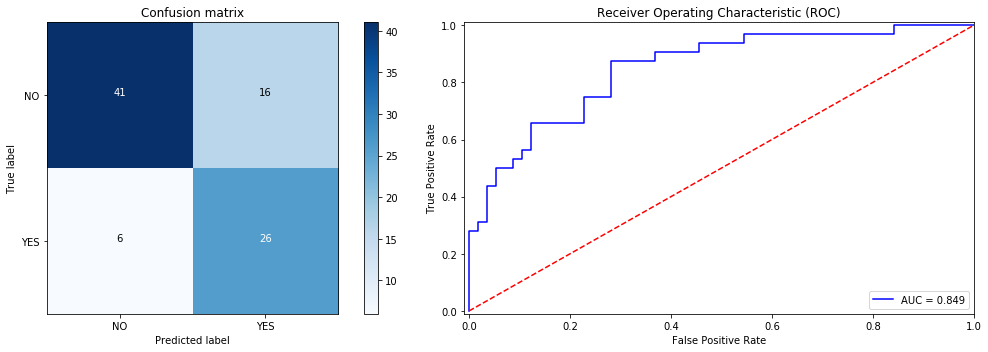

In [27]:
plot_cf_matrix_and_roc(clf, X_train, y_train, X_test, y_test, pred_y , classes=['NO','YES'])

## Optimize the parameters for better classifier performance

In [28]:
# set different parameters
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1, 1.3],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1, 1.3],
    'penalty': ['l1','l2']
}]

# Logistic Regression with class weight 1:3 for the minority class
clf = LogisticRegression(
    class_weight={0:1,1:3},
    n_jobs=-1 # Use all CPU
)

# load GridSearchCV for the best parameter evaluation
search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    n_jobs=-1,
    scoring='recall'
)

# train search object
search.fit(X_train, y_train)

# predict the on the test data
pred_y_p = search.predict(X_test)



     Class Precision Accuracy Recall ROC-AUC    AUC F1-score
0  [0. 1.]     0.614    0.753  0.844   0.773  0.846    0.711




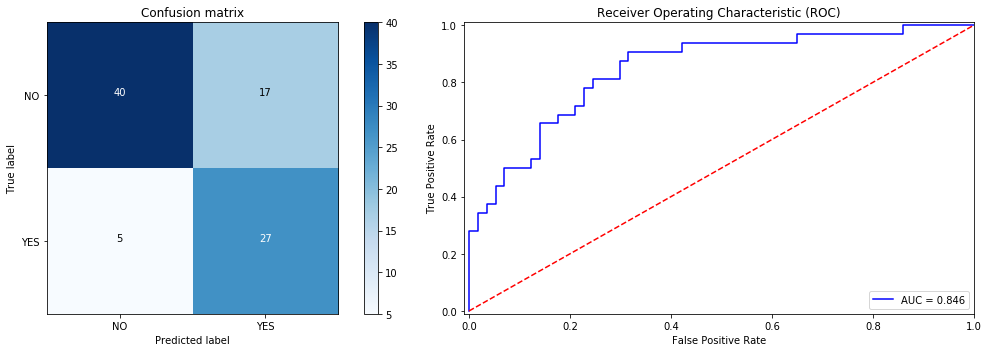

In [29]:
plot_cf_matrix_and_roc(search, X_train, y_train, X_test, y_test, pred_y_p , classes=['NO','YES'])

## Crossvalidate the model

In [30]:
# Cross-validate the recall score on the complete data with Kfold
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(shuffle=True, n_splits=5)
cv_results = cross_val_score(X=X,y=y,estimator=search, cv=kf, scoring='recall')
print("KFold: Cross-validation recall scores:",cv_results)
print("Mean recall score:",cv_results.mean())

KFold: Cross-validation recall scores: [0.95454545 0.9047619  0.76190476 0.85714286 0.9047619 ]
Mean recall score: 0.8766233766233766
